<a href="https://colab.research.google.com/github/zbrubaker/portfolio/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro

Zachary Brubaker

CS-4430

Project 2 -- Face Detection with EigenFaces

You can access this notebook at:

#Import the Dataset

Import the set of faces, then crop the faces in order to remove the background. 

In [1]:
from sklearn.datasets import fetch_lfw_people
bushPhotos = fetch_lfw_people(min_faces_per_person=530, resize=0.5) 

n_samples, h, w = bushPhotos.images.shape

#Split the Bush Photos into Training and Testing

Use ```train_test_split()``` to split the data

In [2]:
input = bushPhotos.data
output = bushPhotos.target

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(input,output, test_size=0.20)

trainSamples = x_train.shape[0]

Now plot representative training images using matplotlib.

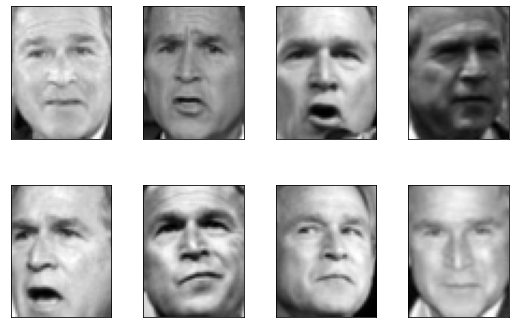

In [3]:
import matplotlib.pyplot as plt

def plot_gallery(images, h, w, n_row=2, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())


plot_gallery(x_train, h, w)

#Generate Eigenfaces From the Training Data

We are going to generate EigenFaces using Principle Component Analysis. We will use these EigenFaces for analyzing test datasets.


First, adjust the original data by the mean.

In [4]:
import numpy as np

tempXTrain = x_train
x_train = x_train - np.mean(x_train,axis=0)


Now, generate the covariance matrix for the training data.

In [5]:
A = x_train
A_T = A.transpose()
covarianceMatrix = np.matmul(A_T, A) / (trainSamples - 1)

Then, generate Eigenvalues and EigenVectors from the covariance matrix.

In [6]:
eigenValues, eigenVectors = np.linalg.eig(covarianceMatrix)

Use the eigen values to order the eigen vectors by highest eigen value. Then, seelect the ```itr``` eigenVectors that make up $95\%$ of the variance for the training data.



In [7]:
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

In [8]:
from pandas.core.internals.base import T

tv = np.sum(eigenValues)
itr = 0
var = 0.0
sum = 0.0
while var < 0.95:
  sum += eigenValues[itr]
  var = sum/tv
  itr = itr + 1

eigenValues = eigenValues[0:itr]
eigenVectors = eigenVectors[:,0:itr]

Now, plot representative EigenFaces from the list.

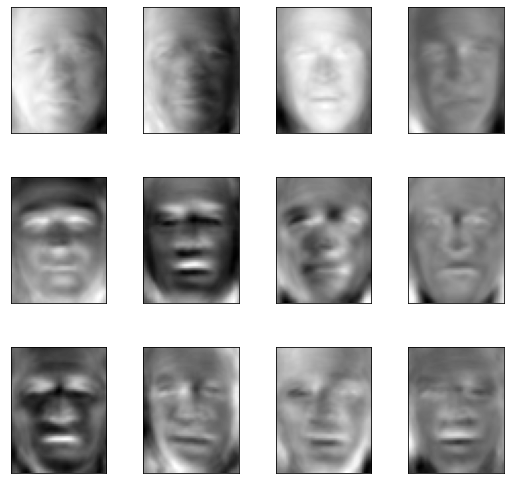

In [9]:
def plot_gallery(eigenVectors, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(eigenVectors[:,i].reshape(h, w), cmap = plt.get_cmap("gray"))
        plt.xticks(())
        plt.yticks(())


plot_gallery(eigenVectors, h, w)

#Test 1: George Bush Classifications

First, multiply the training pictures by the eigenVectors to get their projections into itr-dimensional space. Then, find the average of these itr-dimensional points and save that value for later analysis.

In [10]:
projections = []
for i in range(trainSamples):
  projections.append(np.matmul(x_train[i], eigenVectors))

projections = np.array(projections)

avgPoint = np.average(projections, axis=0)

Now, I am going to find the farthest distance from this average point. I will use this distance as a threshold value in the future. Images that are farther from the averagePoint will not be considered George Bush photos. Images closer than this threshold will be considered George Bush photos.

In [11]:
from numpy.linalg import norm

distances = []

for i in range (x_train.shape[0]):
  difference = norm(avgPoint - np.matmul(x_train[i], eigenVectors))

  distances.append(difference)

print(max(distances))
print(min(distances))

3607.0898
917.54565


Therefore, I will choose ```2300``` to be the threshold value (This value gave the highest amount of accurate classifications between George Bush and Serena Williams)

In [12]:
threshold = 2300

##Classify the Test Data

We are ready to classify the test data. First, subtract the training mean from the images.

In [13]:
from numpy.linalg import norm

x_test = x_test - np.mean(tempXTrain,axis=0)


Now, analyze each picture in the test dataset and classify whether it is a picture of George Bush.

To do this, find the itr-dimension projection of each image by multiplying the image by the eigenVectors. Then, compare the difference of the image's projection and the average point. Images that are farther from the averagePoint will not be considered George Bush photos. Images closer than this threshold will be considered George Bush photos.

In [14]:
yesCount = 0
noCount = 0

for i in range (x_test.shape[0]):
  difference = norm(avgPoint - np.matmul(x_test[i], eigenVectors))

  if difference < threshold:
    yesCount += 1
  else:
    noCount += 1

print("There are {n} images classified as George Bush.".format(n=yesCount))
print("There are {n} images NOT classified as George Bush.".format(n=noCount))
print("Success Rate: {n}".format(n=round(yesCount / (yesCount + noCount), 2)))

There are 84 images classified as George Bush.
There are 22 images NOT classified as George Bush.
Success Rate: 0.79


We can see that the majority (79%) of images are classified as George Bush, so the classification algorithm appears successful!

#Test 2: Classifying Images as George Bush or Serena Williams

First, I need to import all 51 Serena Images. Once I import the faces, I note that Serena has a target value of 10. I use this to grab all images from the dataset with a target value of 10.

In [15]:
faces = fetch_lfw_people(min_faces_per_person=51, resize=0.5) 

In [16]:
serenaFaces = []
serenaTargets = []
for i in range(faces.data.shape[0]):
  if faces.target[i] == 10:
    serenaFaces.append(faces.data[i])
    serenaTargets.append(1)
serenaFaces = np.array(serenaFaces)

Plot representative Serena images from the dataset.

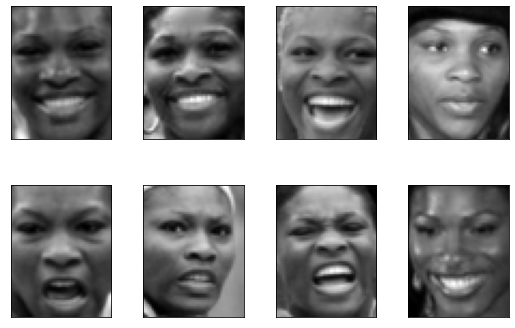

In [17]:
def plot_gallery(images, h, w, n_row=2, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())


plot_gallery(serenaFaces, h, w)

We are ready to classify the Serena images. First, subtract the training mean from the images.

In [18]:
mean = np.mean(tempXTrain,axis=0)

serenaFaces = serenaFaces - mean

Now, analyze each Serena picture and classify whether it is a picture of George Bush.

To do this, find the itr-dimension projection of each image by multiplying the image by the eigenVectors. Then, compare the difference of the image's projection and the average point. Images that are farther from the averagePoint will not be considered George Bush photos. Images closer than this threshold will be considered George Bush photos.

In [19]:
yesCount = 0
noCount = 0

for i in range (serenaFaces.shape[0]):
  testDimension = np.matmul(serenaFaces[i], eigenVectors)
  difference = norm(avgPoint - testDimension)

  if difference < threshold:
    yesCount += 1
  else:
    noCount += 1

print("There are {n} images classified as George Bush.".format(n=yesCount))
print("There are {n} images NOT classified as George Bush.".format(n=noCount))
print("Success Rate: {n}".format(n=round(noCount / (yesCount + noCount), 2)))

There are 9 images classified as George Bush.
There are 43 images NOT classified as George Bush.
Success Rate: 0.83


We can see that the majority (83 %) of Serena images were classified as Serena Williams, so the classification algorithm was successful. 

#Test 3: Plot the most and least "George Bush" Face of Serena Williams

To see if a Serena face is like a Bush face, compare difference of image projection from the average point of Bush images. The Serena image that is closest to the average Bush face is most like a Bush face. The Serena image that is farthest from the average Bush Face is least like a Bush face.

##The Most "George Bush" Face of Serena Williams

([], <a list of 0 Text major ticklabel objects>)

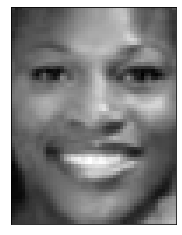

In [20]:
minIndex = -1
minDist = norm(avgPoint - np.matmul(serenaFaces[0], eigenVectors))

for i in range (serenaFaces.shape[0]):
  difference = norm(avgPoint - np.matmul(serenaFaces[i], eigenVectors))
  if difference < minDist:
    minDist = difference
    minIndex = i

plt.figure()
plt.imshow((serenaFaces[minIndex] + mean).reshape(h, w), cmap = plt.get_cmap("gray"))
plt.xticks(())
plt.yticks(())

This image is classified as the Serena image that most closely resembles George Bush.

##The Least "George Bush" Face of Serena Williams


([], <a list of 0 Text major ticklabel objects>)

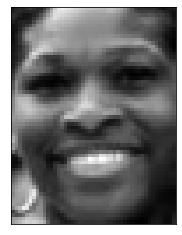

In [21]:
maxIndex = -1
maxDist = -1

for i in range (serenaFaces.shape[0]):
  difference = norm(avgPoint - np.matmul(serenaFaces[i], eigenVectors))
  if difference > maxDist:
    maxDist = difference
    maxIndex = i

plt.figure()
plt.imshow((serenaFaces[maxIndex] + mean).reshape(h, w), cmap = plt.get_cmap("gray"))
plt.xticks(())
plt.yticks(())

This image is classified as the Serena image that least closely resembles George Bush.